In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
housing = pd.read_csv('./data/cleaned_data.csv')
housing.drop('Unnamed: 0', axis=1, inplace=True)
housing.head()

,id,flat_type,floor_area_sqm,resale_price,Tranc_Year,Tranc_Month,mid,hdb_age,max_floor_lvl,commercial,...,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation,total_unit_sold_%,total_unit_rental_%
0,88471,4 ROOM,90.0,680000.0,2016,5,11,15,25,0,...,0,29.427395,1138.633422,78,1,1138.633422,224,0,100.0,0.0
1,122598,5 ROOM,130.0,665000.0,2012,7,8,34,9,0,...,1,58.207761,415.607357,45,1,447.894399,232,0,100.0,0.0
2,170897,EXECUTIVE,144.0,838000.0,2013,7,14,24,16,0,...,0,214.747860,498.849039,39,0,180.074558,188,0,100.0,0.0
3,86070,4 ROOM,103.0,550000.0,2012,4,3,29,11,1,...,1,43.396521,389.515528,20,1,389.515528,253,1,100.0,0.0
4,153632,4 ROOM,83.0,298000.0,2017,12,2,34,4,0,...,0,129.422752,401.200584,74,0,312.025435,208,0,100.0,0.0


#### Features Selection and Data Split

In [3]:
# compared to model 2, I have added 'flat_type' and 'Tranc_year' as features
# However, I do not agree with adding Tranc_Year as a feature, which I would elaborate the reasons later
# It is added as a main purpose of attempting to improve the model 2

x = housing[['floor_area_sqm','max_floor_lvl', 'mid', 'hdb_age','planning_area','flat_type','Tranc_Year', 
             'total_dwelling_units', 'mrt_nearest_distance', 
             'Hawker_Within_2km', 'Mall_Within_2km']]
y = housing[['resale_price']]

x = pd.get_dummies(x, columns=['planning_area','flat_type','Tranc_Year'], drop_first=True)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=86)

#### Verify statistical significance

In [5]:
stats_x = pd.DataFrame(x_train)
stats_x.columns = x.columns
stats_model = sm.OLS(y_train, stats_x).fit() # fit in OLS model in statsmodel using post split trainning data
print(stats_model.summary())

                                 OLS Regression Results                                
Dep. Variable:           resale_price   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          1.765e+05
Date:                Sun, 03 Mar 2024   Prob (F-statistic):                        0.00
Time:                        21:55:32   Log-Likelihood:                     -1.3770e+06
No. Observations:              112353   AIC:                                  2.754e+06
Df Residuals:                  112299   BIC:                                  2.755e+06
Df Model:                          54                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

It looks like the features below have p value that is more than 0.05, which signify they are not statistically insignificant.  
1) Mall_within_2km
2) planning_area_Hougang
3) planning_area_Novena
4) planning_area_Jurong East

However, a high p-value means we are not to reject the null hypothesis, which in this case the hypothesis is that the feature has no statistical significance. It does not necessarily mean the feature has no predictive value in the model, or unable to explain the variance in the data. It might also mean that the data does not offer sufficient evidence to prove the feature significance.  

As the "planning area" is one feature that has been one hot encoded into categorical values, dropping any of these would lead to biased estimate and distorted coefficient. Therefore we would be keeping the above (2) to (4) and remove Mall_within_2km from the features selection.



In [6]:
# feature selection again and check for significance

x = housing[['floor_area_sqm','max_floor_lvl', 'mid', 'hdb_age','planning_area','flat_type','Tranc_Year', 
             'total_dwelling_units', 'mrt_nearest_distance', 
             'Hawker_Within_2km']]
y = housing[['resale_price']]

x = pd.get_dummies(x, columns=['planning_area','flat_type','Tranc_Year'], drop_first=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=22)

stats_x = pd.DataFrame(x_train)
stats_x.columns = x.columns
stats_model = sm.OLS(y_train, stats_x).fit() # fit in OLS model in statsmodel using post split trainning data
print(stats_model.summary())

                                 OLS Regression Results                                
Dep. Variable:           resale_price   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          1.786e+05
Date:                Sun, 03 Mar 2024   Prob (F-statistic):                        0.00
Time:                        21:55:33   Log-Likelihood:                     -1.3773e+06
No. Observations:              112353   AIC:                                  2.755e+06
Df Residuals:                  112300   BIC:                                  2.755e+06
Df Model:                          53                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

#### Scale data

In [7]:
ss = StandardScaler()
ss.fit(x_train)
x_train = ss.transform(x_train)
x_test = ss.transform(x_test)

#### Modeling

In [8]:
# Instantiate models
lr = LinearRegression()
lasso = LassoCV(n_alphas=200)
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

In [9]:
cross_val_score(lr, x_train, y_train, cv=5).mean()

0.8739348803947797

In [10]:
cross_val_score(lasso, x_train, y_train.values.ravel(), cv=5).mean() # needed to apply ravel() as lasso does not accept [row, column]

0.8738360730828783

In [11]:
cross_val_score(ridge, x_train, y_train, cv=5).mean()

0.8739348877206922

All of the three models above performed better than the baseline model (43%) and the model 2 (82%).  
However, It is only a marginal improvement, of merely 6% improvement in R2 from model 2.

In [12]:
lr.fit(x_train, y_train)
print(lr.score(x_train, y_train))
print(lr.score(x_test, y_test))

0.8741306569580147
0.8750810182556741


It shows model has no overfitting issue.

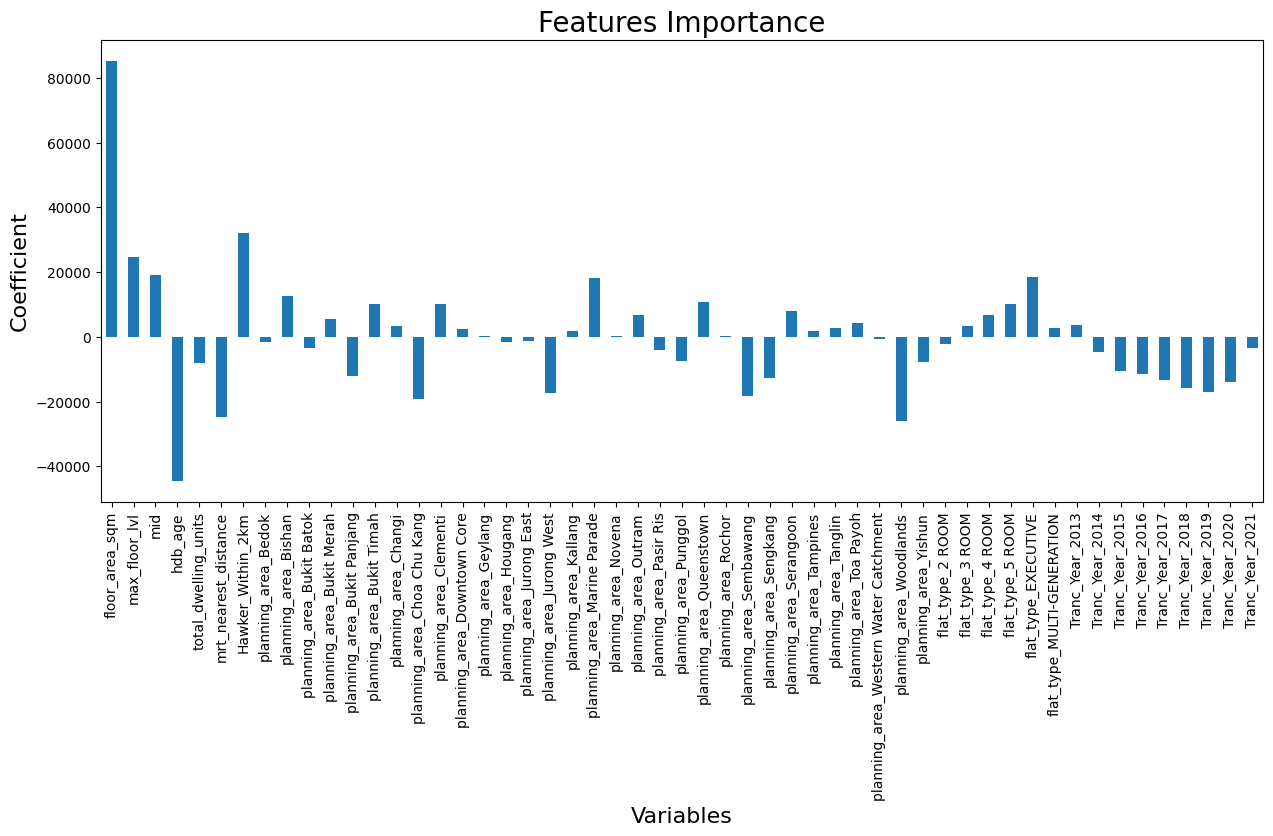

In [13]:
pd.Series(lr.coef_[0], index=x.columns).plot.bar(figsize=(15, 6))
plt.xlabel('Variables',size=16)
plt.ylabel('Coefficient', size=16)
plt.title('Features Importance', size=20)
plt.show()

When it comes to feature importance, aside from the insights identified from model 2, it looks like types of flat and the year that the flat was purchased do have certain impact to the HDB resale price.  

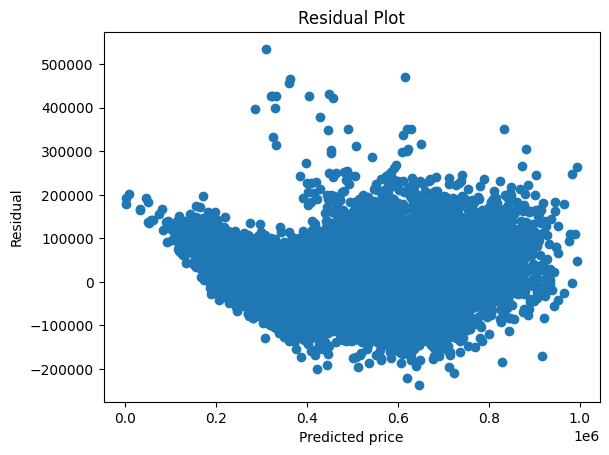

In [14]:
pred = lr.predict(x_test)
residuals = y_test - pred
plt.scatter(pred, residuals)
plt.xlabel('Predicted price')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()

No visible pattern can be identified from the above residual plot, indicating the model is capturing most of the information.

In [15]:
mean_squared_error(y_test, pred, squared=False)

50556.92603036768

A RMSE of about 51k, which is about 16% lower from model 1 (61k), decent improvement.

I would like to bring back the point being made previously, where I do not agree with adding "year" as a feature.  
"Year" feature in itself is a time-series, if it was added as a continuous variable, we assumed that the HDB resale price has a relationship with year. For instance, a coefficient of 20k would simply mean as every year gone by, the HDB resale price would increase by 20k.  
It is a reasonable assumption, where the property prices would "always" go up, but it is not the most sensible assumption when we consider macroeconomics factors, such as recessionary period or hyperinflation period.  

Alternatively, I added the "year" feature as a categorical value through OHE. This eliminate the linear relationship that the "year" feature could have. However, this reduces the forecasting capability of the model. Evidently, when it comes to "year" value that is not in one of the years in the dataset (e.g. 2035), the model would be deemed as obsolete, or completely useless.   

In conclusion, model 3 is merely an attempt to improve the R2 and RMSE in the regression model. It does not necessarily offer the most practical usage in a production environment. This is mainly due to how the model is treating the "tranc_year" data. 

In [16]:
# Export features and coefficient for business case analysis

features = pd.DataFrame(x.columns)
coef = pd.DataFrame(lr.coef_)
coef = coef.T
features_coef = pd.merge(features, coef, left_index=True, right_index=True)
features_coef.rename(columns = {'0_x':'features', '0_y':'coefficient'}, inplace=True)
features_coef.to_csv('./data/features.csv')

#### Kaggle Submission

In [17]:
kaggle_test = pd.read_csv('./data/test.csv')
kaggle_test.head()

C:\Users\heziy\AppData\Local\Temp\ipykernel_7620\1430065199.py:1: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  kaggle_test = pd.read_csv('./data/test.csv')


,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,114982,2012-11,YISHUN,4 ROOM,173,YISHUN AVE 7,07 TO 09,84.0,Simplified,1987,...,92,0,1.433681,103.832924,156.322353,Ahmad Ibrahim Secondary School,218,0,1.436235,103.829987
1,95653,2019-08,JURONG WEST,5 ROOM,986C,JURONG WEST ST 93,04 TO 06,112.0,Premium Apartment,2008,...,45,0,1.339244,103.698896,739.371688,Jurong West Secondary School,199,0,1.335256,103.702098
2,40303,2013-10,ANG MO KIO,3 ROOM,534,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,...,36,0,1.371893,103.851811,305.071191,Anderson Secondary School,245,0,1.374242,103.851430
3,109506,2017-10,WOODLANDS,4 ROOM,29,MARSILING DR,01 TO 03,97.0,New Generation,1979,...,54,0,1.434423,103.773698,433.454591,Woodlands Secondary School,188,0,1.439183,103.774499
4,100149,2016-08,BUKIT BATOK,4 ROOM,170,BT BATOK WEST AVE 8,16 TO 18,103.0,Model A,1985,...,40,0,1.349195,103.741000,217.295361,Bukit Batok Secondary School,223,0,1.348351,103.740873


In [18]:
kaggle_test = kaggle_test[['id','floor_area_sqm','max_floor_lvl', 'mid', 'hdb_age','planning_area','flat_type','Tranc_Year', 
             'total_dwelling_units', 'mrt_nearest_distance', 
             'Hawker_Within_2km']]
kaggle_test = pd.get_dummies(kaggle_test, columns=['planning_area','flat_type','Tranc_Year'], drop_first=True)

In [19]:
kaggle_test.isnull().sum()

id                                          0
floor_area_sqm                              0
max_floor_lvl                               0
mid                                         0
hdb_age                                     0
total_dwelling_units                        0
mrt_nearest_distance                        0
Hawker_Within_2km                        3254
planning_area_Bedok                         0
planning_area_Bishan                        0
planning_area_Bukit Batok                   0
planning_area_Bukit Merah                   0
planning_area_Bukit Panjang                 0
planning_area_Bukit Timah                   0
planning_area_Changi                        0
planning_area_Choa Chu Kang                 0
planning_area_Clementi                      0
planning_area_Downtown Core                 0
planning_area_Geylang                       0
planning_area_Hougang                       0
planning_area_Jurong East                   0
planning_area_Jurong West         

In [20]:
# fill in NaN value as 0, indicating no mall/hawker within the set distance
# This is following the same method in initial data cleaning of the training set

kaggle_test['Hawker_Within_2km'] = kaggle_test['Hawker_Within_2km'].fillna(0)

In [21]:
kaggle_sub = kaggle_test[['id']]
kaggle_test = kaggle_test.drop('id', axis=1)
kaggle_test = ss.transform(kaggle_test)

In [22]:
kaggle_sub['predicted'] = lr.predict(kaggle_test)

In [23]:
kaggle_sub = kaggle_sub.set_index(['id'])
kaggle_sub.head()

,predicted
id,
114982,365426.570033
95653,494324.061670
40303,389750.320679
109506,244518.564034
100149,472524.710394


In [24]:
kaggle_sub.to_csv('./data/kaggle_sub2.csv')